# Courbes de niveau

Devoir pour le 01/11/2020

Emilie Cayatte et Cécile-Aurore Wotawa

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [1]:
# Python Standard Library
# -----------------------
pass

In [2]:
# Third-Party Libraries
# ---------------------

# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [3]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [4]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

#### Exemples d'usage

In [5]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([1., 2.])

In [6]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [7]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [8]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 

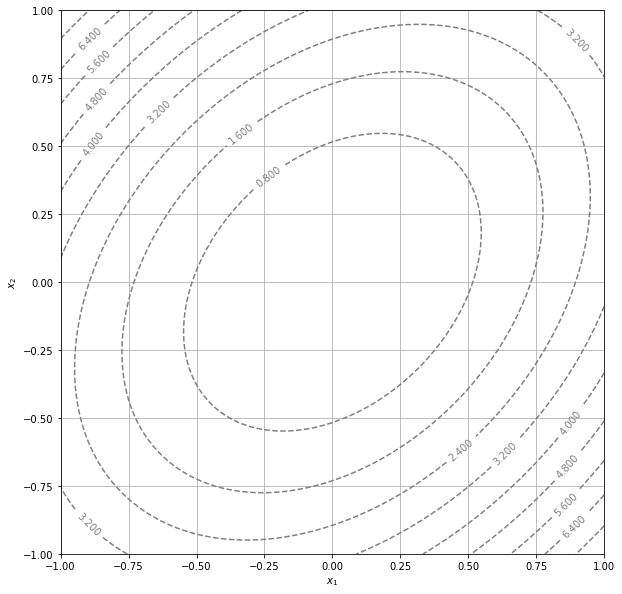

In [9]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [10]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

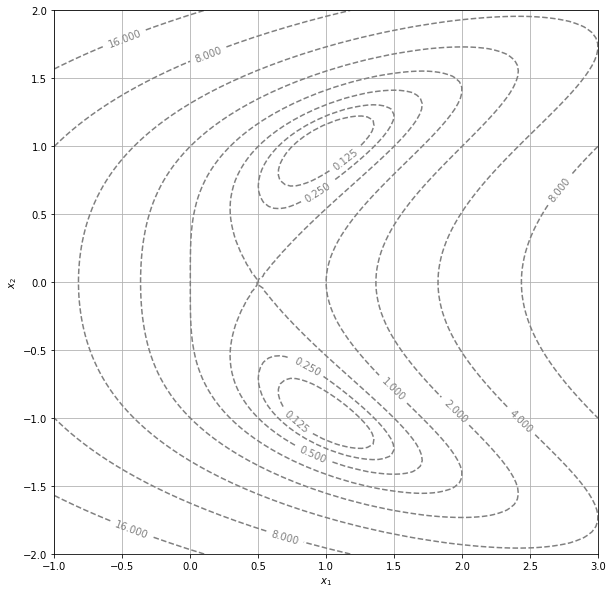

In [11]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [12]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

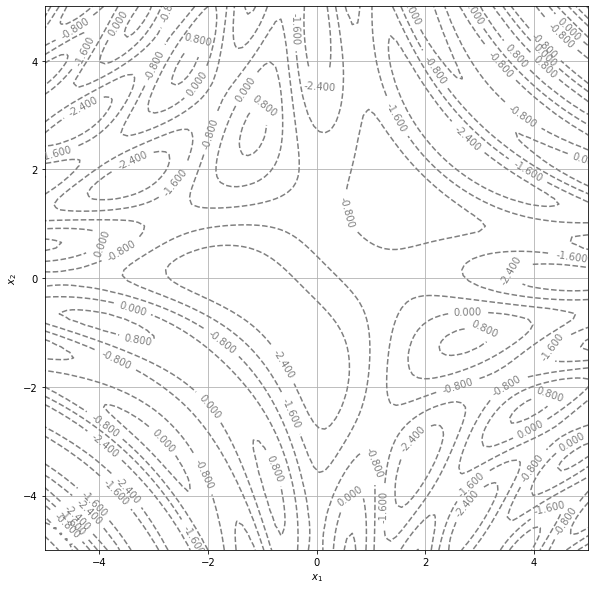

In [13]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?

$\;$
 Montrons que $f^{-1}$ {c} est  compact.
 - f est continue donc comme $\{c\}$ est fermé $f^{-1}$ $\{c\}$  aussi.
 - Supposons que $f^{-1}$ $\{c\}$ n'est pas borné. Il existe $(x_n)_{n\in\mathbb{N}}$ tq  $\lim\nolimits_{n \to \infty} \|x_n\|$ $=$ $+\infty$ et $\forall$ $n$ $\in$  $\mathbb{N}$ $f(x_n)$ $=$ $c$ .
 Absurde car $\lim\nolimits_{n \to \infty} f(x_n)$ $=$ $+\infty$ . Donc $f^{-1}$ $\{c\}$ est borné et dans $\mathbb{R}^{2}$ fermé borné $\Leftrightarrow$ compact.
 
 Donc $f^{-1}$ $\{c\}$  est compact.

 $$

Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$




#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?

On a:

 $p(x_{1},x_{2})$ $=$ $\frac{\partial_{2}f(x_{0})}{\|\nabla f(x_{0}) \|}$$(x_{1}-x_{10})$$-$$\frac{\partial_{1}f(x_{0})}{\|\nabla f(x_{0}) \|}$$(x_{2}-x_{20})$ 
 $$
 $$

 
p est le produit scalaire de $(x-x_{0})$ et $y$ avec
 
$$ y=
\begin{pmatrix}
\frac{\partial_{2}f(x_{0})}{\|\nabla f(x_{0}) \|} \\
- \frac{\partial_{1}f(x_{0})}{\|\nabla f(x_{0}) \|}
\end{pmatrix}
$$ 
  qui est le vecteur normé orthogonal au gradient de $f$ en $x_{0}$ lui même tangent à la courbe. 
  $$
  $$
  Ainsi $p$ représente la deuxième coordonnée de $x$ dans le repère centré en $x_{0}$ de vecteur unitaire tangent et orthogonal à la courbe.


$$

#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

Posons:
$$
\begin{array}{ccccc}
H & : & \mathbb{R}^{2} \times \mathbb{R} & \to & \mathbb{R}^2 \\ 
& & (x,t) & \longmapsto &  (g(x),p(x)-t) 
\end{array}
$$

avec 
$$
\begin{array}{ccccc}
g & : & \mathbb{R}^{2}  & \to & \mathbb{R}\\ 
& & (x_{1},x_{2}) & \longmapsto &  f(x_{1},x_{2})-c 
\end{array}
$$
  


- $p$ est clairement continûment différentiable et $f$ est par hypothèse continûment différentiable également donc $H$ aussi. 
- Montrons que  $\partial_{x}H$ est inversible au voisinage du point $x_{0}$ :
$$  
 \partial_{x}H =
\begin{pmatrix}
\frac{\partial g(x_{0})}{\partial x_{1}}
& 
 \frac{\partial g(x_{0})}{\partial x_{2}}
 \\
\frac{\partial (p-t)(x_{0})}{\partial x_{1}}
&
\frac{\partial (p-t)(x_{0})}{\partial x_{2}}

\end{pmatrix}
$$ 
$$
\begin{vmatrix}
\frac{\partial g(x_{0})}{\partial x_{1}}
& 
 \frac{\partial g(x_{0})}{\partial x_{2}}
 \\
\frac{\partial (p-t)(x_{0})}{\partial x_{1}}
&
\frac{\partial (p-t)(x_{0})}{\partial x_{2}}

\end{vmatrix} = \frac{\partial g(x_{0})}{\partial x_{1}} \times \frac{\partial (p-t)(x_{0})}{\partial x_{2}} - \frac{\partial g(x_{0})}{\partial x_{2}} \times \frac{\partial (p-t)(x_{0})}{\partial x_{1}} 
$$

$$
\begin{vmatrix}
\frac{\partial g(x_{0})}{\partial x_{1}}
& 
 \frac{\partial g(x_{0})}{\partial x_{2}}
 \\
\frac{\partial (p-t)(x_{0})}{\partial x_{1}}
&
\frac{\partial (p-t)(x_{0})}{\partial x_{2}}

\end{vmatrix} = -\|\nabla f(x_{0}) \|^{2} <0 

$$ 
au voisinage de $x_{0}$ par hypothèse.

- Autour d'un ensemble de niveau on a $f(x_{0})=c$ donc $H(x_{0},p(x_{0}))=0$ 
$$
$$


On peut donc appliquer le théorème des fonctions implicites au voisinage de $(x_{0},p(x_{0}))$ et on en déduit qu'il existe des voisinages $U$ de $x$ et $V$ ,  $V=$ $[$ - $\varepsilon$  , $\varepsilon$ $]$ de $t$ et une unique fonction $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ 
continûment différentiable telle que dans $U$ :

$f(x_{1},x_{2})=c$ $\Leftrightarrow$ $(x_{1},x_{2})= \gamma (t)$ où $t=p(x_{1},x_{2})$.

$$

#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.

- On sait que $f(\gamma(t))=c$ donc en posant la fonction
$$
\begin{array}{ccccc}
\phi & : &  \mathbb{R} & \to & \mathbb{R}^2 \\ 
& & t & \longmapsto &  H(\gamma(t),t) 
\end{array}
$$
 
$\forall$ t $\in$ $V$, $\phi(t)=0$ donc $\phi$ est dérivable et 
$\forall$ t $\in$ $V$ $\phi'(t)=0$

En utilisant l'expression de $\phi$ on obtient;

$0= \partial H_{x}(\gamma(t),t)\cdot \gamma'(t)+ \partial H_{t}(\gamma(t),t)\cdot 1$

Or on a vu que $\partial H_{x}$ inversible donc 
$\gamma'(t)= -\partial H_{x}(\gamma(t),t)^{-1} \cdot\partial H_{t}(\gamma(t),t)$


$\partial H_{x}^{-1}$ est injective donc $\gamma'(t) \ne 0$ 
- On sait que $f(\gamma(t))=c$ donc $\nabla (f(\gamma))=0$
Donc $0= \nabla f( \gamma(t)) \cdot \gamma'(t)$ 
 ce qui conclut l'orthogonalité. 

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [14]:
N = 100
eps = 10**(-5) #On choisit epsilon=10^(-5) pour avoir une convergence rapide.


#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [15]:
def Newton(F, x0, y0, eps=eps, N=N):
    inv_jac = np.dot(np.linalg.inv(J(F)(x0,y0)),F(x0,y0))
    x = x0 - inv_jac[0]
    y = y0 - inv_jac[1]
    
    for i in range(N):
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        else:
            x0, y0 = x, y
            inv_jac = np.dot(np.linalg.inv(J(F)(x0,y0)),F(x0,y0))
            x = x0 - inv_jac[0]
            y = y0 - inv_jac[1]
    else:
        raise ValueError(f"no convergence in {N} steps.")

#### Tâche 2

Testez votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x_1 = x_2$ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

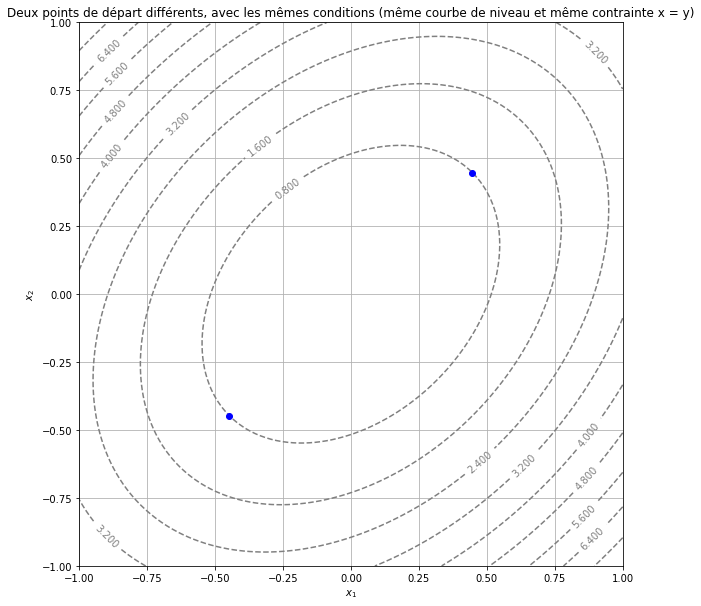

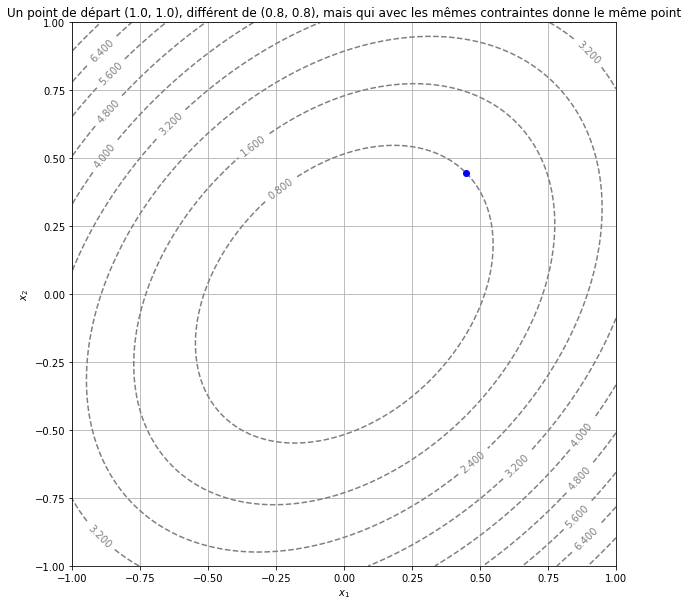

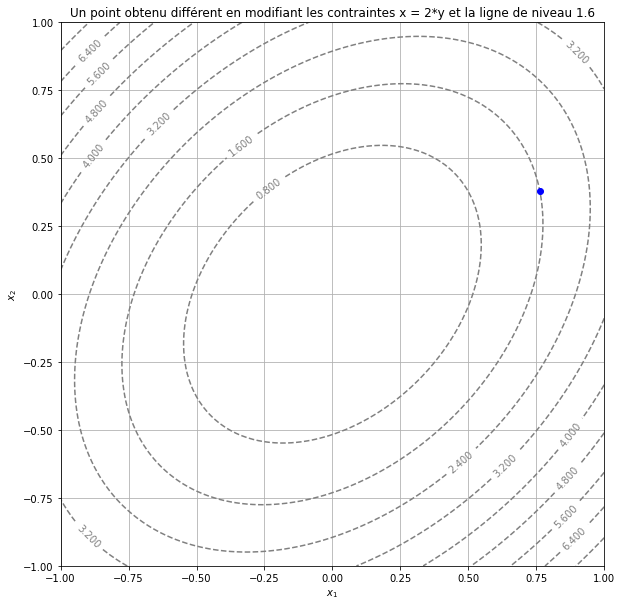

In [16]:
def g1(x1,x2):
    return np.array([f1(x1,x2) - 0.8, x1 - x2])

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

plt.title("Deux points de départ différents, avec les mêmes conditions (même courbe de niveau et même contrainte x = y)")
plt.plot(Newton(g1, 0.8, 0.8, eps, N)[0], Newton(g1, 0.8, 0.8, eps, N)[1], 'bo')
plt.plot(Newton(g1, -0.8, -0.8, eps, N)[0], Newton(g1, -0.8, -0.8, eps, N)[1], 'bo')

plt.show()

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

plt.title("Un point de départ (1.0, 1.0), différent de (0.8, 0.8), mais qui avec les mêmes contraintes donne le même point")
plt.plot(Newton(g1, 1.0, 1.0, eps, N)[0], Newton(g1, 1.0, 1.0, eps, N)[1], 'bo')

plt.show()

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

def g2(x1,x2):
    return np.array([f1(x1,x2) - 1.6, x1 - 2*x2])

plt.title("Un point obtenu différent en modifiant les contraintes x = 2*y et la ligne de niveau 1.6")
plt.plot(Newton(g2, 0.8, 0.8, eps, N)[0], Newton(g2, 0.8, 0.8, eps, N)[1], 'bo')
plt.show()

### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

On cherche à tracer une courbe de niveau à partir d'une fonction $f$ et d'un point de référence $(x_0, y_0)$. 

Plusieurs contraintes sont imposées :
- générer une suite de $N$ points (le point initial $(x_0, y_0)$ étant inclus) sur la courbe de niveau $f(x, y) = c$ avec $c = f(x_0, y_0)$
- chaque point "suivant", qu'on note $(x_1, y_1)$, doit être à une distance $\delta > 0$ du point précédent $(x_0, y_0)$ et aussi "à droite" de $(x_0, y_0)$ quand on regarde dans la direction de $\nabla f(x_0, y_0)$.

Pour cela, on commence par définir une fonction $g$ qui prend en compte deux contraintes : celle qui définit la courbe de niveau $f(x, y) = c$ en première composante, et la distance $\delta > 0$ entre les deux points en deuxième composante. Soit pour cette deuxième contrainte, il suffit que le point suivant $(x_1, y_1)$ soit sur le cercle de centre $(x_0, y_0)$ et de rayon $\delta$.

Ainsi, à chaque étape (c'est-à-dire pour obtenir le point suivant), on applique la méthode de Newton à la fonction $g$ en choisissant judicieusement son point de départ. Le point de départ correspond au point situé à droite du gradient $\nabla f(x_0, y_0)$ sur le cercle de centre $(x_0, y_0)$ et de rayon $\delta$, obtenu par rotation de 90° vers la droite du gradient (puis en le normant correctement).

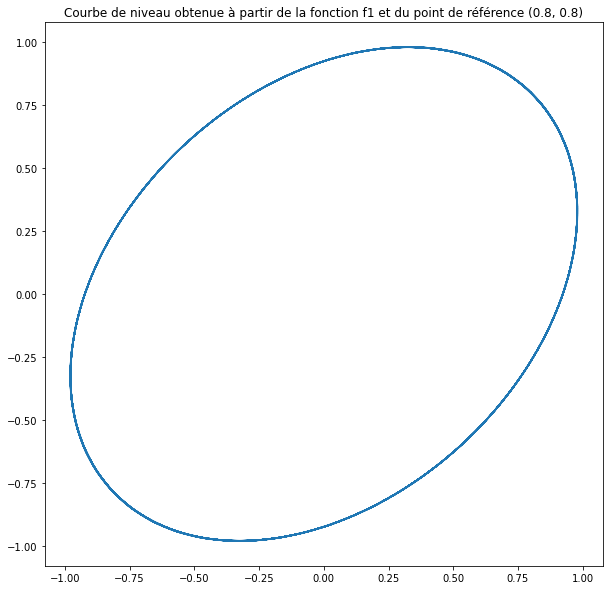

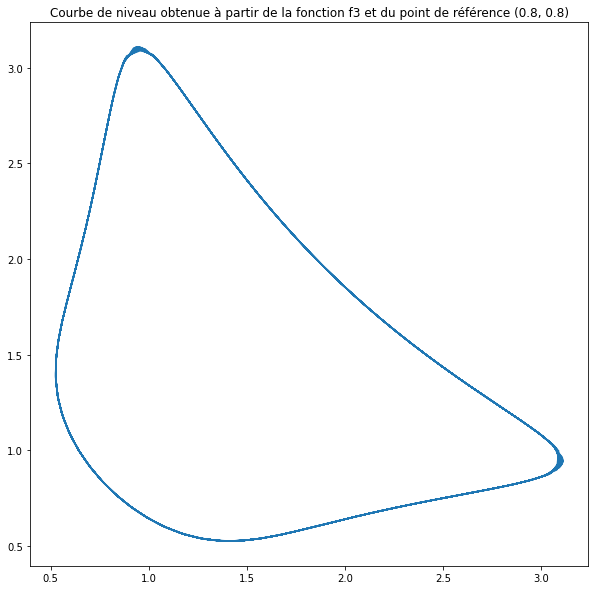

In [17]:
def level_curve(f, x0, y0, delta=0.1, N=1000, eps=eps):
   #pour optimiser le programme, on commence par créer un array de la bonne dimension, avec que des 0
   coord = np.empty(shape = (2, N)) 
   
   #on peut affecter le premier point
   coord[0][0] = x0
   coord[1][0] = y0

   #le point de référence définit la courbe de niveau souhaité
   c = f(x0, y0)

   #on définit notre fonction avec les contraintes imposées, soit la courbe de niveau et le prochain point à une distance delta 
   def g(x1, y1):
      return np.array([f(x1, y1) - c, (x1 - x0)**2 + (y1 - y0)**2 - delta**2])
   
   for i in range(N-1):
      gradi = grad(f)(x0, y0)
      grad_rot = np.array([gradi[1], -gradi[0]]) #rotation de 90° vers la droite du gradient
      point_int = grad_rot * delta/np.linalg.norm(grad_rot) #point intermédiaire : on norme correctement le vecteur
      point_depart = np.array([point_int[0]+x0, point_int[1]+y0]) #point de départ : on n'oublie pas de partir du point précédent (x0,y0)
      tab = Newton(g, point_depart[0], point_depart[1], eps, N) #on applique la méthode de Newton à la fonction g définie ci dessus pour obtenir le prochain point
      x0, y0 = tab[0], tab[1]
      coord[0][i+1] = x0
      coord[1][i+1] = y0
   
   return coord

plt.title("Courbe de niveau obtenue à partir de la fonction f1 et du point de référence (0.8, 0.8)")
plt.plot(level_curve(f1, 0.8, 0.8)[0], level_curve(f1, 0.8, 0.8)[1])
plt.show()

plt.title("Courbe de niveau obtenue à partir de la fonction f3 et du point de référence (0.8, 0.8)")
plt.plot(level_curve(f3, 0.8, 0.8)[0], level_curve(f3, 0.8, 0.8)[1])
plt.show()

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

En étant (raisonnablement) optimiste, on peut se limiter à tester l'intersection entre la droite formée par les deux derniers points produits avec la droite issue des deux premiers points. On peut considérer qu'en général la courbe de niveau n'est pas "auto-intersectante" et donc que la première intersection aura lieu avec le "premier" segment.

En effet, en prenant l'exemple de la fonction de Rosenbrock qui présente une courbe de niveau "auto-intersectante", on comprend qu'en choisissant un $c$ légèrement supérieur ou légèrement inférieur à $c_0$ tel que la courbe de niveau $f(x, y) = c_0$ soit auto-intersectante, on a que la courbe de niveau $f(x, y) = c$ n'est pas auto-intersectante.

Ainsi, en posant l'ensemble $E = \{c\in\mathbb{R} |$ la courbe de niveau $f(x, y) = c$ soit auto-intersectante$\}$, on a $E$ est un ensemble négligeable. Ces courbes de niveaux sont donc "rares".

Pour l'implémentation de la nouvelle fonction :

On remet la fonction level_curve et on rajoute dans la boucle for une condition if qui vérifie s'il y a intersection entre la droite formée par le premier segment avec la droite formée par les deux derniers points ajoutés au array.

S'il y a intersection, on vérifie ensuite que le point d'intersection se trouve dans les deux segments (le "premier" et celui formé par les deux derniers points obtenus). On vérifie donc que les coordonnées soient comprises entre le maximum des minimums et le minimum des maximums.

Les équations de droite utilisées dans le programme suivant sont de la forme $y =$pente$*x +$ord_orig, avec pente $:= \frac{y_1 - y_0}{x_1 - x_0}$ et ord_orig $:= \frac{y_0*x_1 - y_1*x_0}{x_1 - x_0}$.

Pour calculer le point d'intersection, on vérifie d'abord que les deux droites ne sont pas parallèles. Ensuite, on utilise une équation paramétrique pour le premier segment, qu'on note $[AB]$ de la forme :
\begin{array}{rcl}
x &=& x_A + t*(x_B - x_A)\\
y &=& y_A + t*(y_B - y_A)
\end{array}
avec $t\in\mathbb{[0, 1]}$

In [18]:
def level_curve_bis(f, x0, y0, delta=0.1, N=1000, eps=eps):
    # on remet la fonction level_curve et on rajoute dans la boucle for une condition if qui vérifie s'il y a intersection entre la droite formée par le premier segment avec la droite formée par les deux derniers points ajoutés au array.
    # on retourne alors immédiatemment le tableau lorsque la condition est vérifiée
    coord = np.empty(shape = (2, N))
    coord[0][0] = x0
    coord[1][0] = y0
    c = f(x0, y0)

    def g(x1, y1):
        return np.array([f(x1, y1) - c, (x1 - x0)**2 + (y1 - y0)**2 - delta**2])

    for i in range(N-1):
        gradi = grad(f)(x0, y0)
        grad_rot = np.array([gradi[1], -gradi[0]])
        point_int = grad_rot * delta/np.linalg.norm(grad_rot)
        point_depart = np.array([point_int[0]+x0, point_int[1]+y0]) 
        tab = Newton(g, point_depart[0], point_depart[1], eps, N)
        x0, y0 = tab[0], tab[1]

        if i == 1: #on prépare la pente et l'ordonnée à l'origine pour les prochaines boucles
            pente = (coord[1][1] - coord[1][0])/(coord[0][1] - coord[0][0])
            ord_orig = (coord[1][0]*coord[0][1] - coord[1][1]*coord[0][0])/(coord[0][1] - coord[0][0])

        if i > 1: #on regarde à chaque fois s'il faut s'arrêter
            pente_bis = (coord[1][i] - coord[1][i-1])/(coord[0][i] - coord[0][i-1])

            if pente_bis != pente:
                ord_orig_bis = (coord[1][i-1]*coord[0][i] - coord[1][i]*coord[0][i-1])/(coord[0][i] - coord[0][i-1])
                t = (pente_bis*coord[0][0] + ord_orig_bis - coord[1][0])/(coord[1][1] - coord[1][0] - pente_bis*(coord[0][1] - coord[0][0]))
                abs_inters = coord[0][0] + t*(coord[0][1] - coord[0][0])
                ord_inters = coord[1][0] + t*(coord[1][1] - coord[1][0])

                if max(min(coord[0][0], coord[0][1]), min(coord[0][i], coord[0][i-1]))<=abs_inters<=min(max(coord[0][0], coord[0][1]),max(coord[0][i], coord[0][i-1])) and max(min(coord[1][0], coord[1][1]), min(coord[1][i], coord[1][i-1])) <= ord_inters <= min(max(coord[1][0], coord[1][1]), max(coord[1][i], coord[1][i-1])):
                    coord[0][i+1] = x0
                    coord[1][i+1] = y0
                    return coord[:i+1, :i+1] #il faut retirer les points "préparés au début en trop"

                else:
                    coord[0][i+1] = x0
                    coord[1][i+1] = y0
                    
        else:
            coord[0][i+1] = x0
            coord[1][i+1] = y0
    return coord


#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.

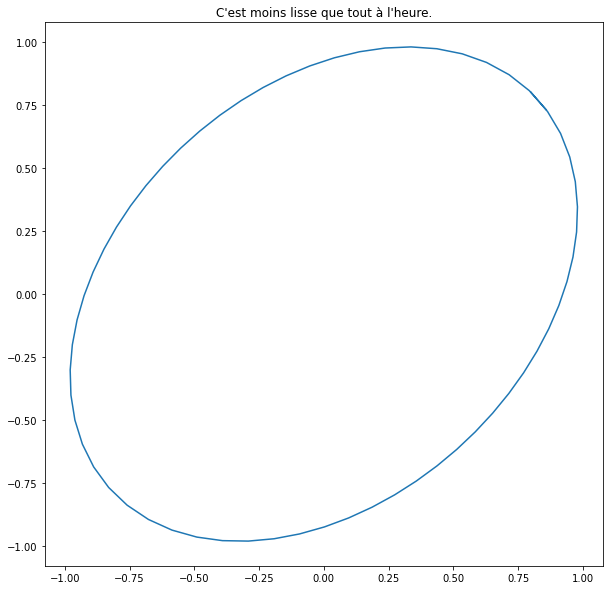

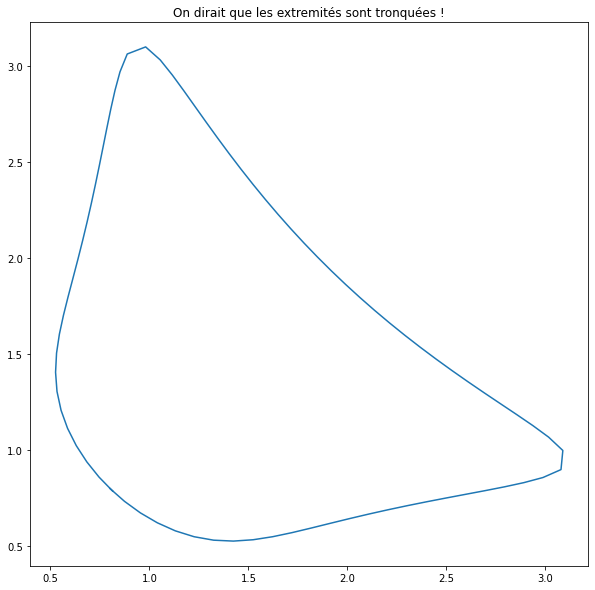

In [19]:
plt.title("C'est moins lisse que tout à l'heure.")
plt.plot(level_curve_bis(f1, 0.8, 0.8)[0], level_curve_bis(f1, 0.8, 0.8)[1])

plt.show()

plt.title("On dirait que les extremités sont tronquées !")
plt.plot(level_curve_bis(f3, 0.8, 0.8)[0], level_curve_bis(f3, 0.8, 0.8)[1])
plt.show()

## Post-traitement

Pour améliorer le rendu des courbes de niveau, il est tentant de diminuer la distance $\delta$ entre deux points consécutifs. Malheureusement, dans des cas d'usage réalistes, il est fréquent que la fonction $f$ soit beaucoup plus complexe que les exemples qui nous avons considérés. Le nombre de fois où cette fonction est appelée est alors le principal facteur qui détermine le temps de calcul des lignes de niveau. On cherche donc dans cette section à améliorer la qualité visuelle des résultats sans faire exploser le nombre d'évaluation de la fonction $f$. On va chercher à résoudre ce problème en reliant les points successifs par des chemins plus "flexibles" que des segments de droites, ayant le potentiel de mieux coller aux lignes de niveau.

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.

On cherche  $\gamma(t) = (x(t), y(t))$
avec $x(t) = a + bt + ct^2$ $\;$ et $\;$ $y(t) = d + et + ft^2$ $\;$ tel que: 



$$
\left\{
        \begin{array}{ll}
        \gamma(0)=P_{1} \\
        \gamma(1)=P_{2} \\
        \gamma'(0) \; est \; de \; même \; sens \; et \; direction \; que \; u_{1} \; \Rightarrow \gamma'(0)= \lambda \times u_{1} \; avec \; \lambda > 0 \\ 
        \gamma'(1) \; est \; de \; même \; sens \; et \; direction \; que \; u_{2} \; \Rightarrow \gamma'(0)= \mu \times u_{2} \; avec \; \mu > 0 \\
        u_{1}= (u_{1x},u_{1y}) , \; u_{2}= (u_{2x},u_{2y}), \; P_{1}= (P_{1x},P_{1y}), \; P_{2}= (P_{2x},P_{2y})

    \end{array}
\right.


\Leftrightarrow 
\left\{
        \begin{array}{ll}
        a=P_{1x} \\
        d=P_{1y} \\
        a +b+ c= P_{2x} \Rightarrow \gamma'(0)= \lambda \times u_{1}  \\ 
        d +e +f= P_{2y} \\
        b= \lambda \times u_{1x} \\
        e= \lambda \times u_{1y} \\
        2c + b= \mu \times u_{2x} \\
        2f + e = \mu \times u_{2y}

    \end{array}
\right.


\Leftrightarrow 
\left\{
        \begin{array}{ll}
        a=P_{1x} \\
        b= \lambda \times u_{1x} \\
        c= \frac{1}{2} \times ( \mu \times u_{2x} - \lambda \times u_{1x})  \\ 
        d = P_{1y} \\
        e= \lambda \times u_{1y} \\
        f= \frac{1}{2} \times ( \mu \times u_{2y} - \lambda \times u_{1y})  \\
        \lambda = 2 \times \frac{(P_{2x}-P_{1x})\times u_{2y} -(P_{2y}-P_{1y})\times u_{2x}}{u_{1x}u_{2y}-u_{2x}u_{1y}} \\
        \mu = 2 \times \frac{(P_{2y}-P_{1y})\times u_{1x} -(P_{2x}-P_{1x})\times u_{1y}}{u_{1x}u_{2y}-u_{2x}u_{1y}} \\

    \end{array}
\right.
 $$
 on a donc 3 conditions:
 $$
\left\{
        \begin{array}{ll}
       u_{1} \wedge u_{2} \neq 0
     \\ 
     \lambda > 0
     \\ 
     \mu > 0 

    \end{array}
\right.

#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




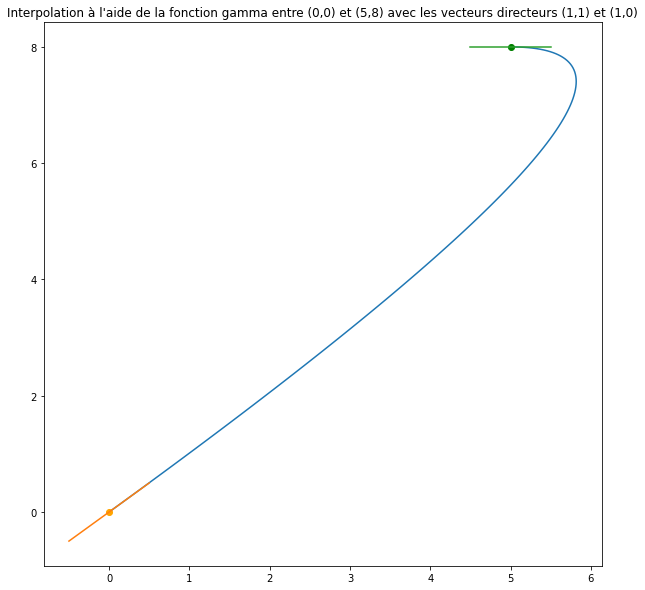

In [20]:
def gamma(t, P1, P2, u1, u2):
    # on vérifie que les trois conditions déterminées à la question 8 sont vérifiées et on applique la fonction gamma obtenue
    # sinon on trace un chemin rectiligne interpolant linéairement les points P1 et P2
    
    if np.cross(u1,u2) != 0 and np.vdot((P2[0]-P1[0], P2[1]-P1[1]), u1) > 0 and np.vdot((P2[0]-P1[0], P2[1]-P1[1]), u2) > 0:
        u1_norm = u1/np.linalg.norm(u1)
        u2_norm = u2/np.linalg.norm(u2)
        lambd = 2 * ((P2[0]-P1[0])*u2[1] - (P2[1]-P1[1])*u2[0])/(u1[0]*u2[1]-u2[0]*u1[1])
        mu = 2 * ((P2[1]-P1[1])*u1[0] - (P2[0]-P1[0])*u1[1])/(u1[0]*u2[1]-u2[0]*u1[1])
        a = P1[0]
        b = lambd * u1[0]
        c = 0.5 * (mu*u2[0] - lambd*u1[0])
        d = P1[1]
        e = lambd * u1[1]
        f = 0.5 * (mu*u2[1] - lambd*u1[1])
        gamma = (a + b*t + c*(t**2), d + e*t + f*(t**2))
    else:
        nv_t = t*(P2[0] - P1[0]) + P1[0]
        pente = (P2[1] - P1[1])/(P2[0] - P1[0])
        ord_orig = (P1[1]*P2[0] - P1[0]*P2[1])/(P2[0] - P1[0])
        gamma = (nv_t, pente*nv_t + ord_orig)
    return gamma

def tangente(u, P, t):
    return (t, (u[1]/u[0])*(t - P[0]) + P[1])

t = np.linspace(0, 1, 100)
plt.title("Interpolation à l'aide de la fonction gamma entre (0,0) et (5,8) avec les vecteurs directeurs (1,1) et (1,0)")
plt.plot(gamma(t, (0,0), (5,8), (1,1), (1,0))[0], gamma(t, (0,0), (5,8), (1,1), (1,0))[1])
plt.plot(0,0,'o',color="orange")
plt.plot(5,8,'go')
plt.plot(tangente((1,1), (0,0), t-0.5)[0], tangente((1,1), (0,0), t-0.5)[1])
plt.plot(tangente((1,0), (5,8), t+4.5)[0], tangente((1,0), (5,8), t+4.5)[1])
plt.show()

### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

In [21]:
def level_curve_ter(f, x0, y0, oversampling, delta=0.1, N=1000, eps=eps):
    # on remet la fonction 2 et on réalise les modifications à partir de la fonction si et seulement si oversampling > 1
    
    if oversampling == 1:
        return level_curve_bis(f, x0, y0, delta, N, eps)

    elif oversampling > 1:
        coord = np.empty(shape = (2, N*oversampling)) #on calcule N*oversampling coordonnées : N coordonnées et on rajoute oversampling-1 points entre chaque point
        coord[0][0] = x0
        coord[1][0] = y0
        c = f(x0, y0)

        def g(x1, y1):
            return np.array([f(x1, y1) - c, (x1 - x0)**2 + (y1 - y0)**2 - delta**2])

        for i in range(N-1):
            #on commence par calculer le prochain point non interpolé
            gradi = grad(f)(x0, y0)
            grad_rot = np.array([gradi[1], -gradi[0]]) 
            point_int = grad_rot * delta/np.linalg.norm(grad_rot) 
            point_depart = np.array([point_int[0]+x0, point_int[1]+y0]) 
            tab = Newton(g, point_depart[0], point_depart[1], eps, N)
            x1, y1 = tab[0], tab[1]

            if i == 0:
                #on réalise l'interpolation entre le point initial et le prochain point, qui vient d'être calculé
                #pour cela on utilise la fonction gamma qui réalise l'interpolation avec un nombre oversampling+1 de points (les deux points "principaux" plus oversampling-1 points interpolés)
                #on réalise l'affectation grâce au slicing
                coord[0][i*oversampling: (i+1)*oversampling+1] = gamma(np.linspace(0,1,oversampling+1), (x0, y0), (x1, y1), (grad(f)(x0,y0)[1], -grad(f)(x0, y0)[0]), (grad(f)(x1, y1)[1], -grad(f)(x1, y1)[0]))[0]
                coord[1][i*oversampling: (i+1)*oversampling+1] = gamma(np.linspace(0,1,oversampling+1), (x0, y0), (x1, y1), (grad(f)(x0,y0)[1], -grad(f)(x0, y0)[0]), (grad(f)(x1, y1)[1], -grad(f)(x1, y1)[0]))[1]
                x0, y0 = x1, y1
            
            if i == 1:
                #on prépare en plus la pente et l'ordonnée à l'origine pour les prochaines boucles
                coord[0][i*oversampling: (i+1)*oversampling+1] = gamma(np.linspace(0,1,oversampling+1), (x0, y0), (x1, y1), (grad(f)(x0,y0)[1], -grad(f)(x0, y0)[0]), (grad(f)(x1, y1)[1], -grad(f)(x1, y1)[0]))[0]
                coord[1][i*oversampling: (i+1)*oversampling+1] = gamma(np.linspace(0,1,oversampling+1), (x0, y0), (x1, y1), (grad(f)(x0,y0)[1], -grad(f)(x0, y0)[0]), (grad(f)(x1, y1)[1], -grad(f)(x1, y1)[0]))[1]
                pente = (coord[1][oversampling] - coord[1][0])/(coord[0][oversampling] - coord[0][0])
                ord_orig = (coord[1][0]*coord[0][oversampling] - coord[1][oversampling]*coord[0][0])/(coord[0][oversampling] - coord[0][0])
                x0, y0 = x1, y1

            if i > 1:
                #on regarde en plus s'il faut s'arrêter
                pente_bis = (coord[1][i*oversampling] - coord[1][(i-1)*oversampling])/(coord[0][i*oversampling] - coord[0][(i-1)*oversampling])

                if pente_bis != pente:
                    ord_orig_bis = (coord[1][(i-1)*oversampling]*coord[0][i*oversampling] - coord[1][i*oversampling]*coord[0][(i-1)*oversampling])/(coord[0][i*oversampling] - coord[0][(i-1)*oversampling])
                    t = (pente_bis*coord[0][0] + ord_orig_bis - coord[1][0])/(coord[1][oversampling] - coord[1][0] - pente_bis*(coord[0][oversampling] - coord[0][0]))
                    abs_inters = coord[0][0] + t*(coord[0][oversampling] - coord[0][0])
                    ord_inters = coord[1][0] + t*(coord[1][oversampling] - coord[1][0])
                    coord[0][i*oversampling: (i+1)*oversampling+1] = gamma(np.linspace(0,1,oversampling+1), (x0, y0), (x1, y1), (grad(f)(x0,y0)[1], -grad(f)(x0, y0)[0]), (grad(f)(x1, y1)[1], -grad(f)(x1, y1)[0]))[0]
                    coord[1][i*oversampling: (i+1)*oversampling+1] = gamma(np.linspace(0,1,oversampling+1), (x0, y0), (x1, y1), (grad(f)(x0,y0)[1], -grad(f)(x0, y0)[0]), (grad(f)(x1, y1)[1], -grad(f)(x1, y1)[0]))[1]
                    x0, y0 = x1, y1

                    if max(min(coord[0][0], coord[0][oversampling]), min(coord[0][i*oversampling], coord[0][(i-1)*oversampling]))<=abs_inters<=min(max(coord[0][0], coord[0][oversampling]),max(coord[0][i*oversampling], coord[0][(i-1)*oversampling])) and max(min(coord[1][0], coord[1][oversampling]), min(coord[1][i*oversampling], coord[1][(i-1)*oversampling])) <= ord_inters <= min(max(coord[1][0], coord[1][oversampling]), max(coord[1][i*oversampling], coord[1][(i-1)*oversampling])):
                        return coord[:(i+1)*oversampling, :(i+1)*oversampling]

                else:
                    coord[0][i*oversampling: (i+1)*oversampling+1] = gamma(np.linspace(0,1,oversampling+1), (x0, y0), (x1, y1), (grad(f)(x0,y0)[1], -grad(f)(x0, y0)[0]), (grad(f)(x1, y1)[1], -grad(f)(x1, y1)[0]))[0]
                    coord[1][i*oversampling: (i+1)*oversampling+1] = gamma(np.linspace(0,1,oversampling+1), (x0, y0), (x1, y1), (grad(f)(x0,y0)[1], -grad(f)(x0, y0)[0]), (grad(f)(x1, y1)[1], -grad(f)(x1, y1)[0]))[1]
                    x0, y0 = x1, y1
            
        return coord

#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.

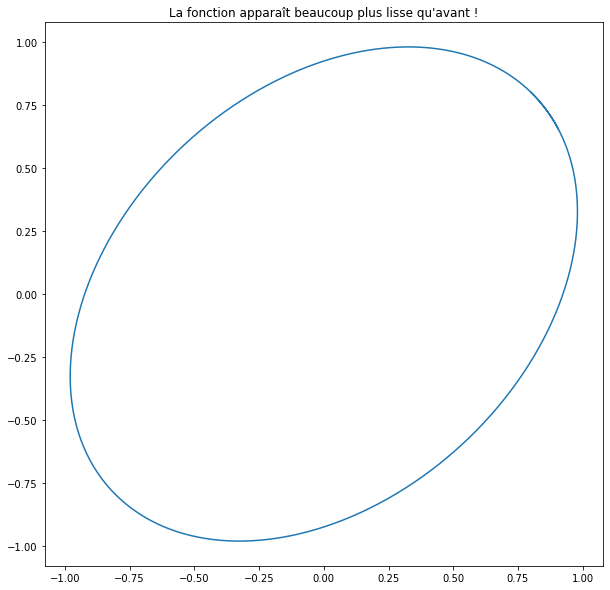

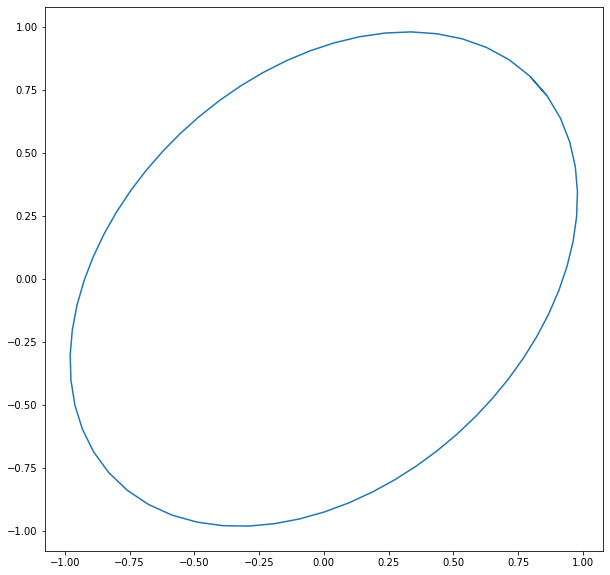

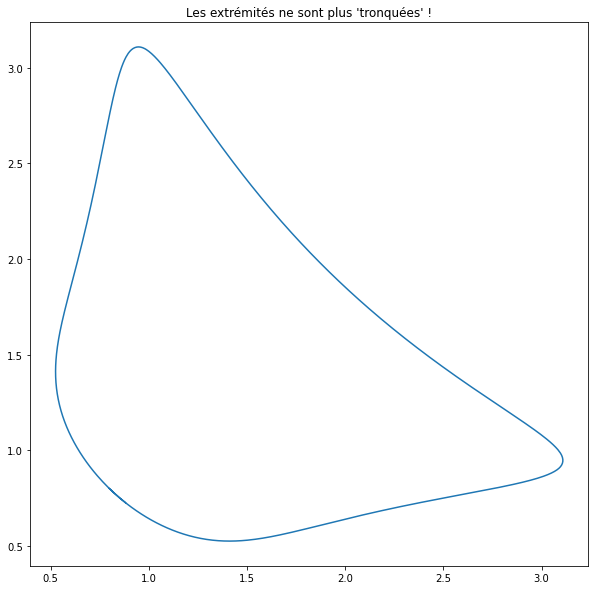

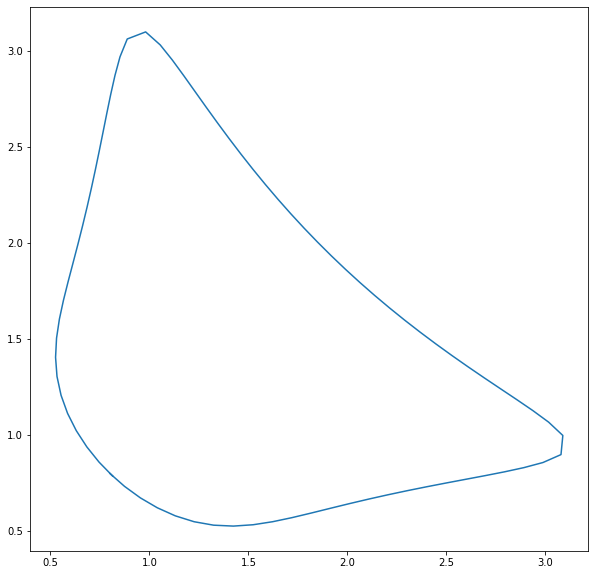

In [22]:
plt.title("La fonction apparaît beaucoup plus lisse qu'avant !")
plt.plot(level_curve_ter(f1, 0.8, 0.8, 10)[0], level_curve_ter(f1, 0.8, 0.8, 10)[1])

plt.show()

plt.plot(level_curve_bis(f1, 0.8, 0.8)[0], level_curve_bis(f1, 0.8, 0.8)[1])

plt.show()

plt.title("Les extrémités ne sont plus 'tronquées' !")
plt.plot(level_curve_ter(f3, 0.8, 0.8, 10)[0], level_curve_ter(f3, 0.8, 0.8, 10)[1])

plt.show()

plt.plot(level_curve_bis(f3, 0.8, 0.8)[0], level_curve_bis(f3, 0.8, 0.8)[1])
plt.show()